We want to check whether DeGAS can be used to maximize the probability of being in a set of states during the evolution of a system

In [1]:
import torch
from torch import distributions

### A simple univariate dynamical system

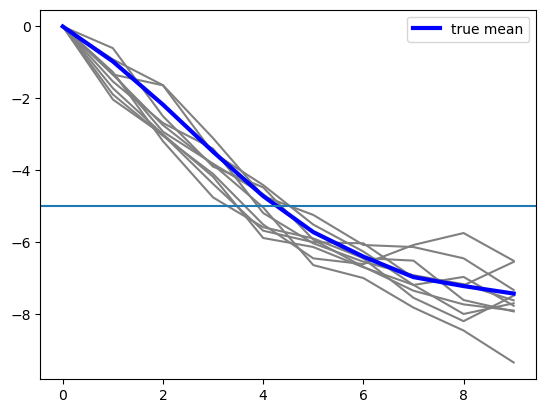

In [ ]:
from cps.original_models import *

T = 10

def original_model(T, x0, r, K, h):

    x = torch.zeros(T)
    x[0] = x0

    dt = 0.1

    for i in range(1, T):

        x[i] = x[i-1] + dt*r*x[i-1] + dt*K*x[i-1]**2 - dt*h + distributions.Normal(0, 0.5).sample()
        
    return x 

orig_traj = generate_traj(original_model, 100, {'T': T, 'x0': 0, 'r': 2.5, 'K': 0.5, 'h': 10})

plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')
plt.axhline(y = -5)

In [78]:
from optimization import *

soga_program = """
array[11] x;
newx = 0.;

for i in range(11){

    x[i] = newx;
    
    term1 = _r*x[i];

    term2 = _K*x[i];
    term2 = term2*x[i];

    newx = x[i] + 0.1*term1 + 0.1*term2 - 0.1*_h + gauss(0., 0.5);
} end for;
"""

compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)
output_dist = start_SOGA(cfg, params_dict={'r': 2.5, 'K': 0.5, 'h': 10.})

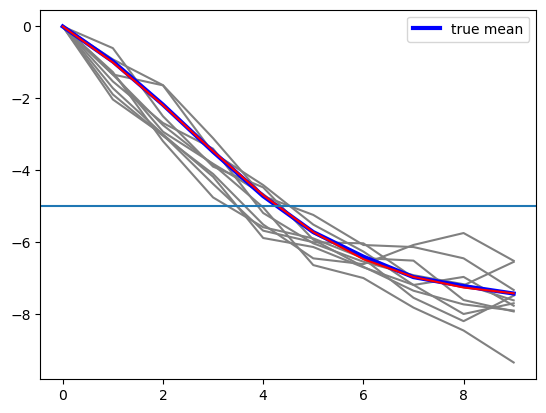

In [79]:
from cps.original_models import *


plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')
plt.plot(range(T), output_dist.gm.mean().detach().numpy()[:T], color='red', label='soga mean')
plt.axhline(y = -5)

In [ ]:
# The loss maximize the probability of being > -5 at the final time step
loss = lambda dist : -(1 - dist.gm.marg_cdf(torch.tensor([-5.]), idx=10))

# creates cfg 
compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)

# initialize parameters
params = {'r': 2.5, 'K': 0.5, 'h': 10.}
params_dict = initialize_params(params)

output_dist = start_SOGA(cfg, params_dict=params_dict)

# gradient based optimization
optimize(cfg, params_dict, loss, n_steps=100, lr=0.01)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")



r: 2.4900007247924805 K: 0.5099998712539673 h: 9.990004539489746  loss: -9.894371032714844e-06
r: 2.4015512466430664 K: 0.5986247658729553 h: 9.901625633239746  loss: -0.0034122467041015625
r: 2.3030614852905273 K: 0.6974780559539795 h: 9.80338191986084  loss: -0.08600819110870361
r: 2.1822152137756348 K: 0.8185465931892395 h: 9.682730674743652  loss: -0.4715467095375061
r: 2.0548174381256104 K: 0.9442909359931946 h: 9.553964614868164  loss: -0.8455621004104614
r: 1.9591343402862549 K: 1.0360311269760132 h: 9.454723358154297  loss: -0.955303430557251
r: 1.9021925926208496 K: 1.0889675617218018 h: 9.393959045410156  loss: -0.9800170660018921
r: 1.8696321249008179 K: 1.1183260679244995 h: 9.358221054077148  loss: -0.9874508380889893
r: 1.8496167659759521 K: 1.1358261108398438 h: 9.335636138916016  loss: -0.9905264377593994
r: 1.835715889930725 K: 1.1476503610610962 h: 9.319571495056152  loss: -0.9921703338623047
Optimization performed in  19.33
r: 1.82583749294281
K: 1.1558879613876343
h

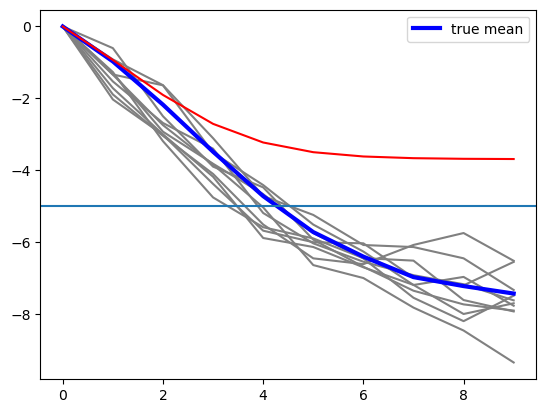

In [85]:

compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)
output_dist = start_SOGA(cfg, params_dict)


plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')
plt.plot(range(T), output_dist.gm.mean().detach().numpy()[:T], color='red', label='soga mean')
plt.axhline(y=-5)

# Two dimensional example

## Damped Oscillator

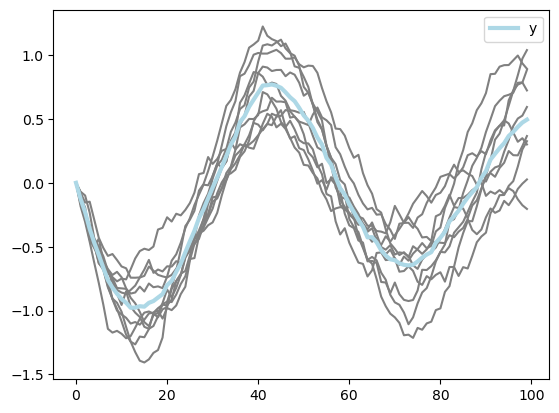

In [41]:
from cps.original_models import *

def original_model(T, x0, y0, a, b, c):

    x = torch.zeros(T)
    y = torch.zeros(T)
    x[0] = x0
    y[0] = y0

    dt = 0.1

    for i in range(1, T):

        x[i] = x[i-1] + dt*y[i-1] + distributions.Normal(0, 0.05).sample()
        y[i] = y[i-1] - dt*a*x[i-1] - dt*b*y[i-1] - dt*c*x[i-1]**3 + distributions.Normal(0, 0.05).sample()
    
    return x, y

x_list = []
y_list = []

init_params = {'T': 100, 'x0': 1., 'y0': 0., 'a': 1.0, 'b': 0.2, 'c': 0.1}


for _ in range(10):

    x, y = original_model(**init_params)
    x_list.append(x)
    y_list.append(y)

x_list = torch.stack(x_list)
y_list = torch.stack(y_list)

plot_traj_set(y_list, single_traj=10, color='lightblue', label='y')
plt.legend()

In [111]:
from optimization import *

soga_program = """
array[101] x;
array[101] y;

newx = 1.;
newy = 0.;

for i in range(101){

    x[i] = newx;
    y[i] = newy;
    
    term1y = _a*x[i];
    
    term2y = _b*y[i];

    term3y = _c*y[i];
    term3y = term3y*y[i];
    term3y = term3y*y[i];

    newx = x[i] + 0.1*y[i] + gauss(0., 0.05);
    newy = y[i] - 0.1*term1y - 0.1*term2y - 0.1*term3y + gauss(0., 0.05);

    } end for;
"""

compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)
output_dist = start_SOGA(cfg, params_dict={'a': 1.0, 'b': 0.2, 'c': 0.1})

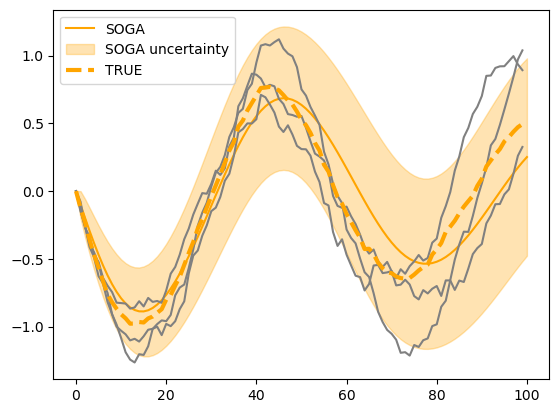

In [112]:
y_idx = [i for i in range(output_dist.gm.n_dim()) if 'y[' in output_dist.var_list[i]]

mean_y = output_dist.gm.mean().detach().numpy()[y_idx]
plt.plot(range(len(y_idx)), mean_y, color='orange', label='SOGA')
std_y = 2*torch.sqrt(torch.diag(output_dist.gm.cov()[y_idx, :][:, y_idx])).detach().numpy()
plt.fill_between(range(len(y_idx)), mean_y - std_y, mean_y + std_y, color='orange', alpha=0.3, label='SOGA uncertainty')

plot_traj_set(y_list, single_traj=3, ls='--', color='orange', label='TRUE')
plt.legend()

In [ ]:
loss = lambda dist : dist.gm.marg_cdf(torch.tensor([0.25]), idx=201) - dist.gm.marg_cdf(torch.tensor([-0.25]), idx=201)

# creates cfg 
compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)

# initialize parameters
params = {'a': 1.0, 'b': 0.2, 'c': 0.1}
params_dict = initialize_params(params)

output_dist = start_SOGA(cfg, params_dict=params_dict)

curr_loss = loss(output_dist)

print(curr_loss.item())

curr_loss.backward()

for key, value in params_dict.items():
    print(f"{key}: grad={value.grad}")

0.43712368607521057
a: grad=-1.3142271041870117
b: grad=0.979412853717804
c: grad=0.48065242171287537


In [107]:
# The loss maximizes the probability of being between -0.25 and 0.25 at the final time step

loss = lambda dist : -(dist.gm.marg_cdf(torch.tensor([0.25]), idx=201) - dist.gm.marg_cdf(torch.tensor([-0.25]), idx=201))

# creates cfg 
compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)

# initialize parameters
params = {'a': 1.0, 'b': 0.2, 'c': 0.1}
params_dict = initialize_params(params)

output_dist = start_SOGA(cfg, params_dict=params_dict)

# gradient based optimization
optimize(cfg, params_dict, loss, n_steps=100, lr=1e-2)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

a: 0.9900000095367432 b: 0.21000000834465027 c: 0.10999999940395355  loss: -0.4142861068248749
a: 0.8991113305091858 b: 0.3069522976875305 c: 0.19759003818035126  loss: -0.5920150876045227
a: 0.8477836847305298 b: 0.39705950021743774 c: 0.2554842531681061  loss: -0.6555875539779663
a: 0.8272347450256348 b: 0.4836893677711487 c: 0.29736411571502686  loss: -0.7056897878646851
a: 0.8128573894500732 b: 0.5668356418609619 c: 0.3300623893737793  loss: -0.7488137483596802
a: 0.7925726771354675 b: 0.6451036930084229 c: 0.3559173047542572  loss: -0.785369873046875
a: 0.7633699178695679 b: 0.7175970077514648 c: 0.3764435946941376  loss: -0.8166632652282715
a: 0.7262609601020813 b: 0.7838467955589294 c: 0.39262157678604126  loss: -0.8434711694717407
a: 0.683982789516449 b: 0.8436365723609924 c: 0.4050658941268921  loss: -0.8660303354263306
a: 0.6396811008453369 b: 0.8971190452575684 c: 0.4143592417240143  loss: -0.8845560550689697
Optimization performed in  560.38
a: 0.6000934839248657
b: 0.94038

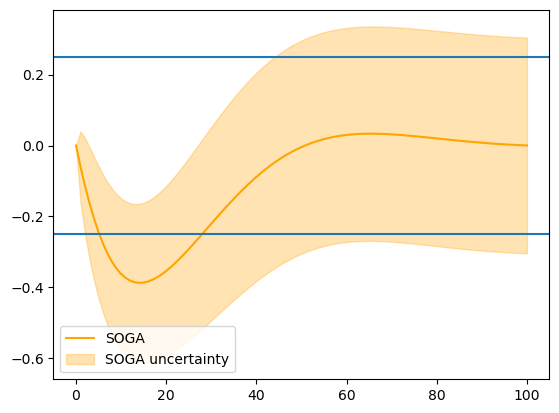

In [109]:
output_dist = start_SOGA(cfg, params_dict=params_dict)

y_idx = [i for i in range(output_dist.gm.n_dim()) if 'y[' in output_dist.var_list[i]]

mean_y = output_dist.gm.mean().detach().numpy()[y_idx]
plt.plot(range(len(y_idx)), mean_y, color='orange', label='SOGA')
std_y = 2*torch.sqrt(torch.diag(output_dist.gm.cov()[y_idx, :][:, y_idx])).detach().numpy()
plt.fill_between(range(len(y_idx)), mean_y - std_y, mean_y + std_y, color='orange', alpha=0.3, label='SOGA uncertainty')


plt.axhline(y=0.25)
plt.axhline(y=-0.25)
plt.legend()

## Lotka-Volterra

Does not work, parameters are too unstable

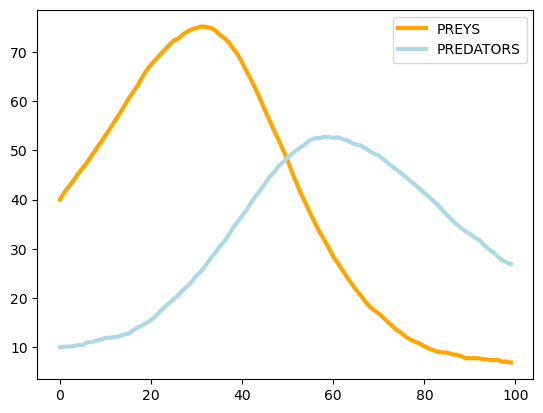

In [1]:
from cps.original_models import *

def original_model(T, x0, y0, a, b, c, d):

    x = torch.zeros(T)
    y = torch.zeros(T)
    x[0] = x0
    y[0] = y0

    dt = 0.1

    for i in range(1, T):

        x[i] = x[i-1] + dt*a*x[i-1] - dt*b*x[i-1]*y[i-1] + distributions.Normal(0, 0.5).sample()
        y[i] = y[i-1] - dt*c*y[i-1] + dt*d*x[i-1]*y[i-1] + distributions.Normal(0, 0.5).sample()
    
    return x, y

x_list = []
y_list = []

init_params = {'T': 100, 'x0': 40., 'y0': 10., 'a': 0.5, 'b': 0.02, 'c': 0.3, 'd': 0.01}


for _ in range(10):

    x, y = original_model(**init_params)
    x_list.append(x)
    y_list.append(y)

x_list = torch.stack(x_list)
y_list = torch.stack(y_list)

plot_traj_set(x_list, single_traj=0, color='orange', label='PREYS')
plot_traj_set(y_list, single_traj=0, color='lightblue', label='PREDATORS')
plt.legend()

In [2]:
from optimization import *

soga_program = """
array[101] x;
array[101] y;

newx = 40.;
newy = 10.;

for i in range(101){

    x[i] = newx;
    y[i] = newy;
    
    term1x = _a*x[i];
    term2x = _b*x[i];
    term2x = term2x*y[i];

    term1y = _c*y[i];
    term2y = _d*x[i];
    term2y = term2y*y[i];

    newx = x[i] + 0.1*term1x - 0.1*term2x + gauss(0., 0.5);
    newy = y[i] - 0.1*term1y + 0.1*term2y + gauss(0., 0.5);

    } end for;
"""

compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)
output_dist = start_SOGA(cfg, params_dict={'a': 0.5, 'b': 0.02, 'c': 0.3, 'd': 0.01})

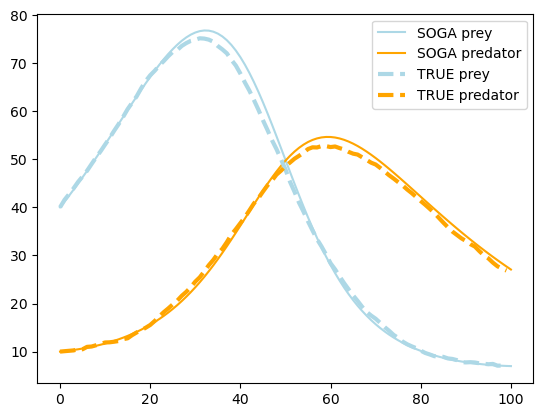

In [3]:
x_idx = [i for i in range(output_dist.gm.n_dim()) if 'x[' in output_dist.var_list[i]]
y_idx = [i for i in range(output_dist.gm.n_dim()) if 'y[' in output_dist.var_list[i]]

plt.plot(range(len(x_idx)), output_dist.gm.mean().detach().numpy()[x_idx], color='lightblue', label='SOGA prey')
plt.plot(range(len(y_idx)), output_dist.gm.mean().detach().numpy()[y_idx], color='orange', label='SOGA predator')

plot_traj_set(x_list, single_traj=0, ls='--', color='lightblue', label='TRUE prey')
plot_traj_set(y_list, single_traj=0, ls='--', color='orange', label='TRUE predator')
plt.legend()

In [8]:
# The loss maximize the probability of predators being < 40 starting from t=20

loss = lambda dist : 1-dist.gm.marg_cdf(torch.tensor([40.]*80), idx=list(range(121, 201))) 

# creates cfg 
compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)

# initialize parameters
params = {'a': 0.5, 'b': 0.02, 'c': 0.3, 'd': 0.005}
params_dict = initialize_params(params)

output_dist = start_SOGA(cfg, params_dict=params_dict)

# gradient based optimization
optimize(cfg, params_dict, loss, n_steps=100, lr=1e-5)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")


a: 0.5000100135803223 b: 0.019989999011158943 c: 0.3000100255012512 d: 0.004989999812096357  loss: 0.9561197757720947
a: 0.5000199675559998 b: 0.01998000033199787 c: 0.3000200390815735 d: 0.004979999735951424  loss: 0.9564498662948608
a: 0.5000298619270325 b: 0.01997000351548195 c: 0.30003005266189575 d: 0.004969999194145203  loss: 0.9567766189575195
a: 0.5000396370887756 b: 0.019960008561611176 c: 0.30004003643989563 d: 0.004959998186677694  loss: 0.9570996761322021


KeyboardInterrupt: 

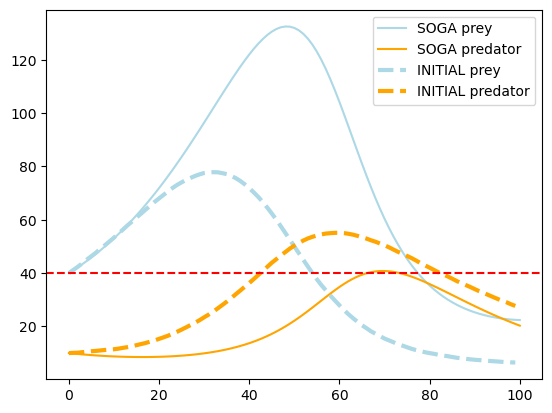

In [15]:
compiledFile = compile2SOGA_text(soga_program)
cfg = produce_cfg_text(compiledFile)
output_dist = start_SOGA(cfg, params_dict)

x_idx = [i for i in range(output_dist.gm.n_dim()) if 'x[' in output_dist.var_list[i]]
y_idx = [i for i in range(output_dist.gm.n_dim()) if 'y[' in output_dist.var_list[i]]

plt.plot(range(len(x_idx)), output_dist.gm.mean().detach().numpy()[x_idx], color='lightblue', label='SOGA prey')
plt.plot(range(len(y_idx)), output_dist.gm.mean().detach().numpy()[y_idx], color='orange', label='SOGA predator')

plot_traj_set(x_list, single_traj=0, ls='--', color='lightblue', label='INITIAL prey')
plot_traj_set(y_list, single_traj=0, ls='--', color='orange', label='INITIAL predator')
plt.axhline(y=40, color='red', linestyle='--')
plt.legend()